In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
#from prophet import Prophet

In [33]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [34]:
#df

In [35]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Februar-25", "Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [36]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

#print(df)  # Check that dates are correctly formatted at month-end


In [37]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -2.1431351909817096, p-value: 0.22752700223748779
Hoyre ADF Statistic: -1.8196635186008094, p-value: 0.37074392214204605
Frp ADF Statistic: 1.2116325044195977, p-value: 0.9960652755506311
SV ADF Statistic: -3.143500966393524, p-value: 0.023496976073433522
Sp ADF Statistic: -3.1838888208581144, p-value: 0.02093640394522018
KrF ADF Statistic: -4.707234698517839, p-value: 8.155841832630618e-05
Venstre ADF Statistic: -1.9660630228172478, p-value: 0.30164858101469527
MDG ADF Statistic: -2.585936634044432, p-value: 0.09593885432671917
Rodt ADF Statistic: -3.0468191741656767, p-value: 0.030747424499184044
Andre ADF Statistic: -1.8129280146418307, p-value: 0.3740624451383301


In [38]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [39]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
model_fitted = model.fit(45)  # Choose lag order (5 is an example, tune this)

# Display the summary of the fitted model
#print(model_fitted.summary())

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [40]:
forecast = model_fitted.forecast(df_diff.values[-model_fitted.k_ar:], steps=8)

# Convert forecasted values to a DataFrame
forecast_dates = pd.date_range(start="2025-02-28", periods=8, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)

print(forecast_diff_df)

                  Ap     Hoyre       Frp        SV        Sp       KrF  \
2025-02-28 -0.107791 -0.097854  0.149970  0.002159  0.131143 -0.044588   
2025-03-31 -0.163842 -0.123829  0.388664  0.058561 -0.218240  0.121824   
2025-04-30  0.222829  0.107169 -0.198943 -0.185859  0.211078 -0.122416   
2025-05-31 -0.316419 -0.229098  0.478212  0.121575 -0.072336  0.074728   
2025-06-30  0.064069  0.003703  0.146715 -0.098081 -0.066263  0.024714   
2025-07-31  0.147187  0.068554 -0.098963 -0.125807  0.104964 -0.064933   
2025-08-31 -0.180321 -0.144710  0.306221  0.042998  0.004165  0.022727   
2025-09-30  0.017699 -0.009065  0.150820 -0.042297 -0.118359  0.053306   

             Venstre       MDG      Rodt     Andre  
2025-02-28 -0.064716 -0.005718 -0.000914  0.022587  
2025-03-31  0.053956 -0.037536 -0.011344 -0.049054  
2025-04-30 -0.147888  0.032858 -0.020990  0.075685  
2025-05-31  0.026059 -0.042666  0.002409 -0.037154  
2025-06-30 -0.051501 -0.005735 -0.027029  0.010047  
2025-07-31 -0.0

In [41]:
# Invert differencing (cumulative sum and add back the last observed value)
forecast_original_scale = forecast_diff_df.cumsum() + df.iloc[-1]

In [42]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,18.992209,22.102146,24.249970,8.002159,6.031143,3.355412,4.435284,3.294282,5.599086,3.922587
2025-03-31,18.828367,21.978317,24.638635,8.060720,5.812903,3.477236,4.489240,3.256745,5.587743,3.873533
2025-04-30,19.051196,22.085485,24.439692,7.874861,6.023981,3.354820,4.341352,3.289604,5.566752,3.949218
2025-05-31,18.734777,21.856388,24.917904,7.996436,5.951645,3.429548,4.367411,3.246938,5.569161,3.912064
2025-06-30,18.798846,21.860091,25.064619,7.898355,5.885382,3.454262,4.315910,3.241202,5.542133,3.922111
2025-07-31,18.946034,21.928644,24.965656,7.772548,5.990346,3.389329,4.223954,3.259732,5.525223,3.966909
2025-08-31,18.765713,21.783934,25.271877,7.815546,5.994511,3.412056,4.204004,3.236437,5.521750,3.959299
2025-09-30,18.783412,21.774869,25.422697,7.773249,5.876152,3.465362,4.200678,3.224972,5.503580,3.948408


<Figure size 1200x600 with 0 Axes>

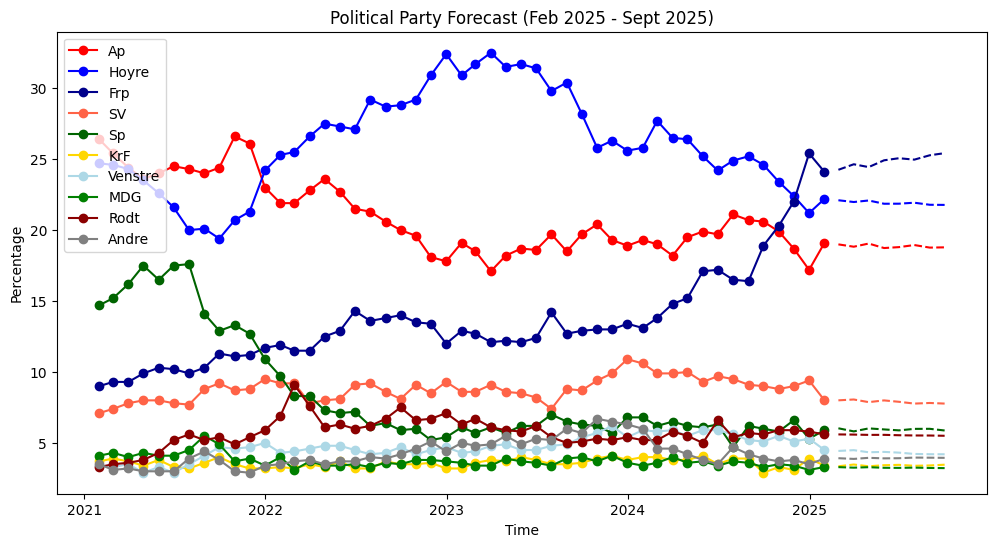

In [43]:
plt.figure(figsize=(12, 6))


# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


plt.figure(figsize=(12, 6))

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast with the same color
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast (Feb 2025 - Sept 2025)")
plt.legend()
plt.show()

In [44]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,18.992209,22.102146,24.249970,8.002159,6.031143,3.355412,4.435284,3.294282,5.599086,3.922587
2025-03-31,18.828367,21.978317,24.638635,8.060720,5.812903,3.477236,4.489240,3.256745,5.587743,3.873533
2025-04-30,19.051196,22.085485,24.439692,7.874861,6.023981,3.354820,4.341352,3.289604,5.566752,3.949218
2025-05-31,18.734777,21.856388,24.917904,7.996436,5.951645,3.429548,4.367411,3.246938,5.569161,3.912064
2025-06-30,18.798846,21.860091,25.064619,7.898355,5.885382,3.454262,4.315910,3.241202,5.542133,3.922111
2025-07-31,18.946034,21.928644,24.965656,7.772548,5.990346,3.389329,4.223954,3.259732,5.525223,3.966909
2025-08-31,18.765713,21.783934,25.271877,7.815546,5.994511,3.412056,4.204004,3.236437,5.521750,3.959299
2025-09-30,18.783412,21.774869,25.422697,7.773249,5.876152,3.465362,4.200678,3.224972,5.503580,3.948408
